## Prepare flow directions and related data from a DEM

With HydroMT-Wflow, a user can choose to build a model in a geographic or projected coordinate system from an input Digital Elevation Model (DEM) and Flow Direction (flwdir) dataset.

While DEM data are often available, this is not the always the case for the flow directions (flwdir). We made the choice to build a Wflow model directly from user provided DEM and flwdir datasets rather than reprojecting a DEM and/or deriving flwdir on the fly. This is because deriving flow directions is often an iterative process to be sure the flow directions matche the terrain and river network. Note that for the best results the flwdir data should be derived from a high-res DEM (<100 m spatial resolution). The HydroMT-Wflow model builder will automatically resample the flwdir data to the model resolution.

Because of this, we prefer to provide this notebook as a possible **pre-processing step** before calling a build a Wflow model with HydroMt-Wflow. Here we use the different [flow directions methods from HydroMT](https://deltares.github.io/hydromt/latest/api.html#flow-direction-methods) and [PyFlwDir](https://deltares.github.io/pyflwdir/latest/index.html)

### Load dependencies

In [1]:
import os
import xarray as xr
import numpy as np
import geopandas as gpd

# pyflwdir
import pyflwdir

# hydromt
from hydromt import DataCatalog, flw

# plot
import matplotlib.pyplot as plt
from matplotlib import cm, colors

### Deriving flow directions from Elevation data

In this example we will use the `merit_hydro` data in the pre-defined `artifact_data` catalog of HydroMT. 

The typical starting point to derive flow direction is a DEM and a river network vector file.
However, just for this example were we already have flow direction data, we will derive the river network from the flow direction data. And then use the DEM and the river network to derive flow directions.


In [2]:
# read data
data_catalog = DataCatalog("artifact_data")
ds_hydro_org = data_catalog.get_rasterdataset(
    "merit_hydro",
    variables=["elevtn", "flwdir", "uparea", "strord"],
    bbox=[12, 46.0, 12.3, 46.2],
)

# derive river network
# Note: this is typically not needed, instead a user supplied river network is used
flwdir_org = flw.flwdir_from_da(ds_hydro_org["flwdir"], ftype="infer", check_ftype=True)
gdf_riv_org = gpd.GeoDataFrame.from_features(
    flwdir_org.streams(uparea=ds_hydro_org["uparea"].values, min_sto=3),
    crs=ds_hydro_org.raster.crs,
)

To derive flow directions from a DEM, you can use the [hydromt.flw.d8_from_dem](https://deltares.github.io/hydromt/latest/_generated/hydromt.flw.d8_from_dem.html#hydromt.flw.d8_from_dem) method of HydroMT.

This method derives D8 flow directions grid from an elevation grid and allows several options to the users:
- **river burning**: provide a river vector layer ``gdf_riv`` with ``uparea`` (km2) or ``rivdph`` column to guide the derivation of flow directions. This is important to get the correct flow directions, especially in flat areas.
 - **outlets**: outlets can be defined at ``edge``s of the grid (defualt) or force all flow to go to the minimum elevation point ``min``. The latter only makes sense if your DEM only is masked to the catchment. Additionnally, the user can also force specific pits locations via ``idxs_pit``.
 - **depression filling**: local depressions are filled based on their lowest pour point level if the pour point depth is smaller than the maximum pour point depth ``max_depth``, otherwise the lowest elevation in the depression becomes a pit. By default ``max_depth`` is set to -1 m filling all local depressions.

In [3]:
# Derive flow directions with outlets at the edges -> this is the default
da_flwdir = flw.d8_from_dem(
    da_elv=ds_hydro_org["elevtn"],
    max_depth=-1,  # max depression poir point depth; -1 means no local pits
    outlets="edge",  # option: "edge" (default), "min", "idxs_pit"
    idxs_pit=None,
    gdf_riv=gdf_riv_org,  # user supplied river network to aid flow direction derivation
    riv_burn_method="uparea",  # options: "fixed" (default), "rivdph", "uparea"
    # riv_depth=5, # fixed river depth in meters, only used if riv_burn_method="fixed"
    # **kwargs to be passed to pyflwdir.dem.fill_depressions
)

# convert to vector for plotting based no minimum stream order
flwdir = flw.flwdir_from_da(da_flwdir, ftype="infer", check_ftype=True)
gdf_riv = gpd.GeoDataFrame.from_features(
    flwdir.streams(min_sto=3), crs=da_flwdir.raster.crs
)

Let's compare the original with the derived flow direction data. Note that we do not see a big difference here, because the river network file that we used was created from the original flow directions.

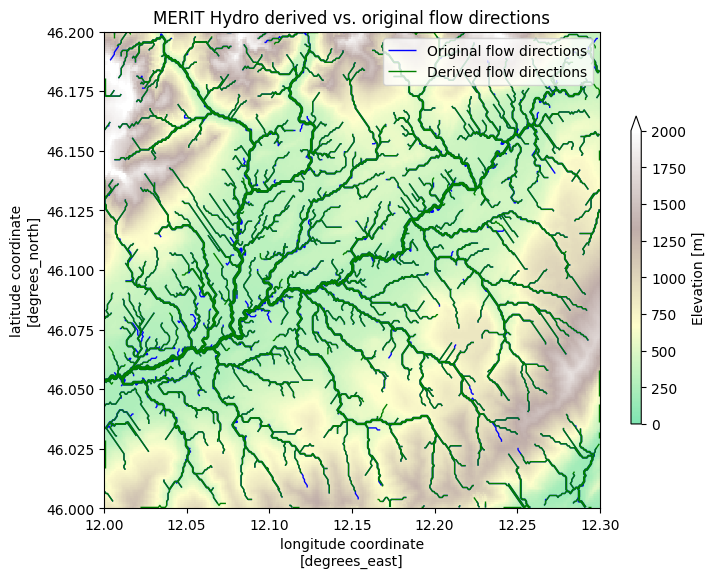

In [4]:
# plot

# initialize image with geoaxes
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

# set some meta data for plots
ds_hydro_org = ds_hydro_org.raster.gdal_compliant()  # spatial
ds_hydro_org["elevtn"].attrs.update(units="m", long_name="Elevation")

# plot elevation
# create nice elevation colormap
cmap_dem = colors.LinearSegmentedColormap.from_list(
    "dem", plt.cm.terrain(np.linspace(0.25, 1, 256))
)
norm_dem = colors.Normalize(vmin=0, vmax=2000)
ds_hydro_org["elevtn"].plot(
    ax=ax,
    zorder=1,
    cbar_kwargs=dict(aspect=30, shrink=0.5),
    alpha=0.5,
    cmap=cmap_dem,
    norm=norm_dem,
)

# plot river network from original flow directions
gdf_riv_org.to_crs(da_flwdir.raster.crs).plot(
    ax=ax,
    color="blue",
    linewidth=gdf_riv_org["strord"] / 3,
    label="Original flow directions",
)

# plot river network from new flow directions
gdf_riv.plot(
    ax=ax,
    color="green",
    linewidth=gdf_riv["strord"] / 3,
    label="Derived flow directions",
)

ax.set_title("MERIT Hydro derived vs. original flow directions")
ax.legend()

## Deriving other DEM and flow directions related data

Once you are satisfied with your flow direction map, you can create additionnal derived variables like upstream area or streamorder that can prove useful for example to build a model based on ``subbasin`` region.

**Note** that to calculating *upstream area* and *stream order* requires all upstream areas to be included, which is not the case for all basins in this example. 
Here are some examples how to do that using PyFlwdir methods.

In [5]:
# Create a new ds_hydro dataset with the riverburn flow directions
ds_hydro = da_flwdir.to_dataset(name="flwdir")
ds_hydro = ds_hydro.raster.gdal_compliant()  # update spatial metadata
dims = ds_hydro.raster.dims

# add hydrological corrected elevation based on Yamazaki et al. (2012)
elevtn = flwdir.dem_adjust(elevtn=ds_hydro_org["elevtn"].values)
attrs = dict(_FillValue=-9999, long_name="corrected elevation", units="m")
ds_hydro["elevtn"] = xr.Variable(dims, elevtn, attrs=attrs)

# uparea (Note that this requires all upstream areas to be included.)
uparea = flwdir.upstream_area(unit="km2")
attrs = dict(_FillValue=-9999, long_name="upstream area", units="km2")
ds_hydro["uparea"] = xr.Variable(dims, uparea, attrs=attrs)

# stream order (Note that this requires all upstream areas to be included.)
strord = flwdir.stream_order()
attrs = dict(_FillValue=np.uint8(225), long_name="stream order", units="-")
ds_hydro["strord"] = xr.Variable(dims, strord, attrs=attrs)

# slope
slope = pyflwdir.dem.slope(
    elevtn=ds_hydro["elevtn"].values,
    nodata=ds_hydro["elevtn"].raster.nodata,
    latlon=ds_hydro.raster.crs.is_geographic,  # True if geographic crs, False if projected crs
    transform=ds_hydro["elevtn"].raster.transform,
)
attrs = dict(_FillValue=-9999, long_name="slope", units="m/m")
ds_hydro["slope"] = xr.Variable(dims, slope, attrs=attrs)

# basin at the pits locations
basins = flwdir.basins(idxs=flwdir.idxs_pit).astype(np.int32)
attrs = dict(_FillValue=0, long_name="basin ids", units="-")
ds_hydro["basins"] = xr.Variable(dims, basins, attrs=attrs)

# basin index file
gdf_basins = ds_hydro["basins"].raster.vectorize()

ds_hydro

<xarray.Dataset> Size: 2MB
Dimensions:      (latitude: 240, longitude: 360)
Coordinates:
  * latitude     (latitude) float64 2kB 46.2 46.2 46.2 46.2 ... 46.0 46.0 46.0
  * longitude    (longitude) float64 3kB 12.0 12.0 12.0 12.0 ... 12.3 12.3 12.3
    spatial_ref  int64 8B 0
Data variables:
    flwdir       (latitude, longitude) uint8 86kB 0 16 1 0 16 1 ... 16 1 0 1 0
    elevtn       (latitude, longitude) float32 346kB 1.021e+03 ... 157.6
    uparea       (latitude, longitude) float64 691kB 0.2199 0.005943 ... 0.2386
    strord       (latitude, longitude) uint8 86kB 2 1 1 2 1 1 2 ... 2 1 1 2 1 2
    slope        (latitude, longitude) float32 346kB 0.5143 0.5413 ... 0.1146
    basins       (latitude, longitude) int32 346kB 1 1 2 2 2 ... 71 72 72 73 73

Text(0.5, 1.0, 'Elevation')

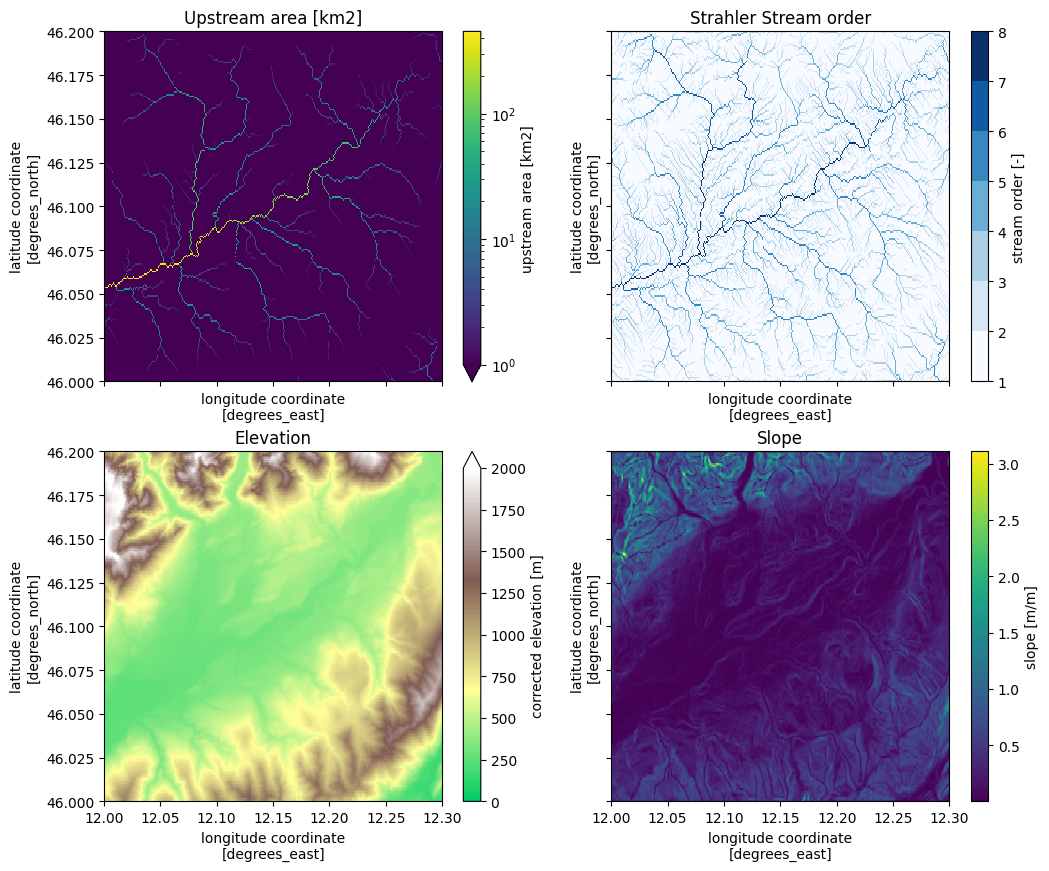

In [6]:
# NOTE that *upstream area* and *stream order* are not correct as not all upstream area is fully included in the domain.

# plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

# plot uparea; use a log scale colormap
ds_hydro["uparea"].plot(
    ax=axes[0, 0],
    norm=colors.LogNorm(vmin=1, vmax=ds_hydro["uparea"].max()),
    cmap="viridis",
)
axes[0, 0].set_title("Upstream area [km2]")

# plot strord
ds_hydro["strord"].plot(
    ax=axes[0, 1], cmap=colors.ListedColormap(cm.Blues(np.linspace(0, 1, 7)))
)
axes[0, 1].set_title("Strahler Stream order")

# plot slope
ds_hydro["slope"].plot(ax=axes[1, 1])
axes[1, 1].set_title("Slope")

# plot basins
# elevation cmap
ds_hydro["elevtn"].plot(ax=axes[1, 0], cmap=cmap_dem, norm=norm_dem)
axes[1, 0].set_title("Elevation")

### Exporting the newly created data and corresponding data catalog

Finally, once we are happy with the new dataset, we can write out the data and create the corresponding data catalog so that it can be re-used to build a new wflow model.

In [7]:
# Export the gridded data as tif files in a new folder
output_path = "./hydro_data"

# export the hydrography data as tif files (one per variable)
ds_hydro.raster.to_mapstack(
    root=os.path.join(output_path, "ds_hydro"),
    driver="GTiff",
)

# export the basin index as geosjon
gdf_basins.to_file(
    os.path.join(output_path, "da_hydro_basins.geojson"), driver="GeoJSON"
)

Now let's prepare the corresponding data catalog: (the writefile command will directly write a file using the lines in the jupyter cell)

In [8]:
%%writefile ./hydro_data/data_catalog.yml
ds_hydro:
  data_type: RasterDataset
  driver: raster
  path: ./ds_hydro/{variable}.tif
  rename:
    slope: lndslp
  meta:
    category: topography
    processing_notes: prepared from MERIT Hydro using hydromt d8_from_dem and pyflwdir
    processing_script: prepare_ldd.ipynb from hydromt_wflow repository

da_hydro_new_index:
  data_type: GeoDataFrame
  driver: vector
  path: ./da_hydro_basins.geojson
  rename:
    value: basid
  meta:
    processing_notes: prepared from MERIT Hydro using hydromt d8_from_dem and pyflwdir
    processing_script: prepare_ldd.ipynb from hydromt_wflow repository


Writing ./hydro_data/data_catalog.yml


And now let's try to load our data again with hydromt:

In [9]:
data_catalog = DataCatalog(data_libs="./hydro_data/data_catalog.yml")

ds_hydro_new = data_catalog.get_rasterdataset("ds_hydro")
ds_hydro_new

<xarray.Dataset> Size: 2MB
Dimensions:      (x: 360, y: 240)
Coordinates:
  * x            (x) float64 3kB 12.0 12.0 12.0 12.0 ... 12.3 12.3 12.3 12.3
  * y            (y) float64 2kB 46.2 46.2 46.2 46.2 ... 46.0 46.0 46.0 46.0
    spatial_ref  int64 8B 0
Data variables:
    basins       (y, x) int32 346kB dask.array<chunksize=(240, 360), meta=np.ndarray>
    elevtn       (y, x) float32 346kB dask.array<chunksize=(240, 360), meta=np.ndarray>
    flwdir       (y, x) uint8 86kB dask.array<chunksize=(240, 360), meta=np.ndarray>
    lndslp       (y, x) float32 346kB dask.array<chunksize=(240, 360), meta=np.ndarray>
    strord       (y, x) uint8 86kB dask.array<chunksize=(240, 360), meta=np.ndarray>
    uparea       (y, x) float64 691kB dask.array<chunksize=(240, 360), meta=np.ndarray>
Attributes:
    category:           topography
    processing_notes:   prepared from MERIT Hydro using hydromt d8_from_dem a...
    processing_script:  prepare_ldd.ipynb from hydromt_wflow repository